<a href="https://colab.research.google.com/github/kvasher/OM/blob/main/Tutorial_Clinically_Accessible_Movement_Analysis_using_Single_and_Multiview_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop to fit biomechanics from smartphone video and estimate gait events

## Setup

In [ ]:
!rm -rf monocular-demos

In [ ]:
!pip install git+https://github.com/peabody124/GaitTransformer
!git clone https://github.com/IntelligentSensingAndRehabilitation/monocular-demos.git

%cd monocular-demos
!pip install .
%cd ..

In [ ]:
import monocular_demos

In [ ]:
import tensorflow as tf

%env MUJOCO_GL=egl

# limit jax and TF from consuming all GPU memory
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using the GPU")
else:
    print("TensorFlow is not using the GPU")


gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


import jax
import jax.numpy as jnp

# Check for available GPU devices
num_devices = jax.local_device_count()
print(f"Found {num_devices} JAX devices:")


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

from matplotlib import pyplot as plt
import numpy as np

import cv2

In [ ]:
# test the body model loads
from monocular_demos.biomechanics_mjx.forward_kinematics import ForwardKinematics

fk = ForwardKinematics()

In [ ]:
# !wget -O jd_run_720p.mp4 https://www.dropbox.com/scl/fi/qcqnu3i1j6ehpmp9d24as/jd_run_720p.mp4?rlkey=5vkn3jhpzxum507qe52bbqe06&dl=1
!wget -O asb_walk.mp4 https://www.dropbox.com/scl/fi/ta57ftdoxayt9q7c23c58/asb_walk_trim2.mp4?rlkey=uv86itruxzknv2p709sr55v1i&dl=1

These 7 blocks (hidden) load in the libraries and repositories need to run this pipeline. Note this will take several minutes.

# Upload a video to your colab environment and then select it with the next cell

A sample video is already upload into the notebook named asb_walk.mp4.

If you would like to upload your own video, simply expand the file browser on the left by clicking the folder icon and drag and drop your mp4 or mov file in the main directory.

In [ ]:
import os

# List files in current directory
files = os.listdir()
files = [f for f in files if 'mp4' in f or 'MOV' in f.upper()]

if len(files) > 1:
    print("Available files:")
    for i, file in enumerate(files):
        print(f"{i+1}. {file}")

    # Prompt user for selection
    choice = int(input("Enter the number of the file to select: ")) - 1
    video_filepath = files[choice]

    print(f"You selected: {video_filepath}")

else:

    assert len(files) == 1, "No videos uploaded"

    video_filepath = files[0]


In [ ]:
# check a frame from the video
cap = cv2.VideoCapture(video_filepath)

ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(frame)

In [ ]:
# If the frame shows up transposed then set this to True
# (Note: the gait transformer overlay will not be correct)
rotated = False

# Run MeTAbs-ACAE on the video to estimate 2D/3D keypoints

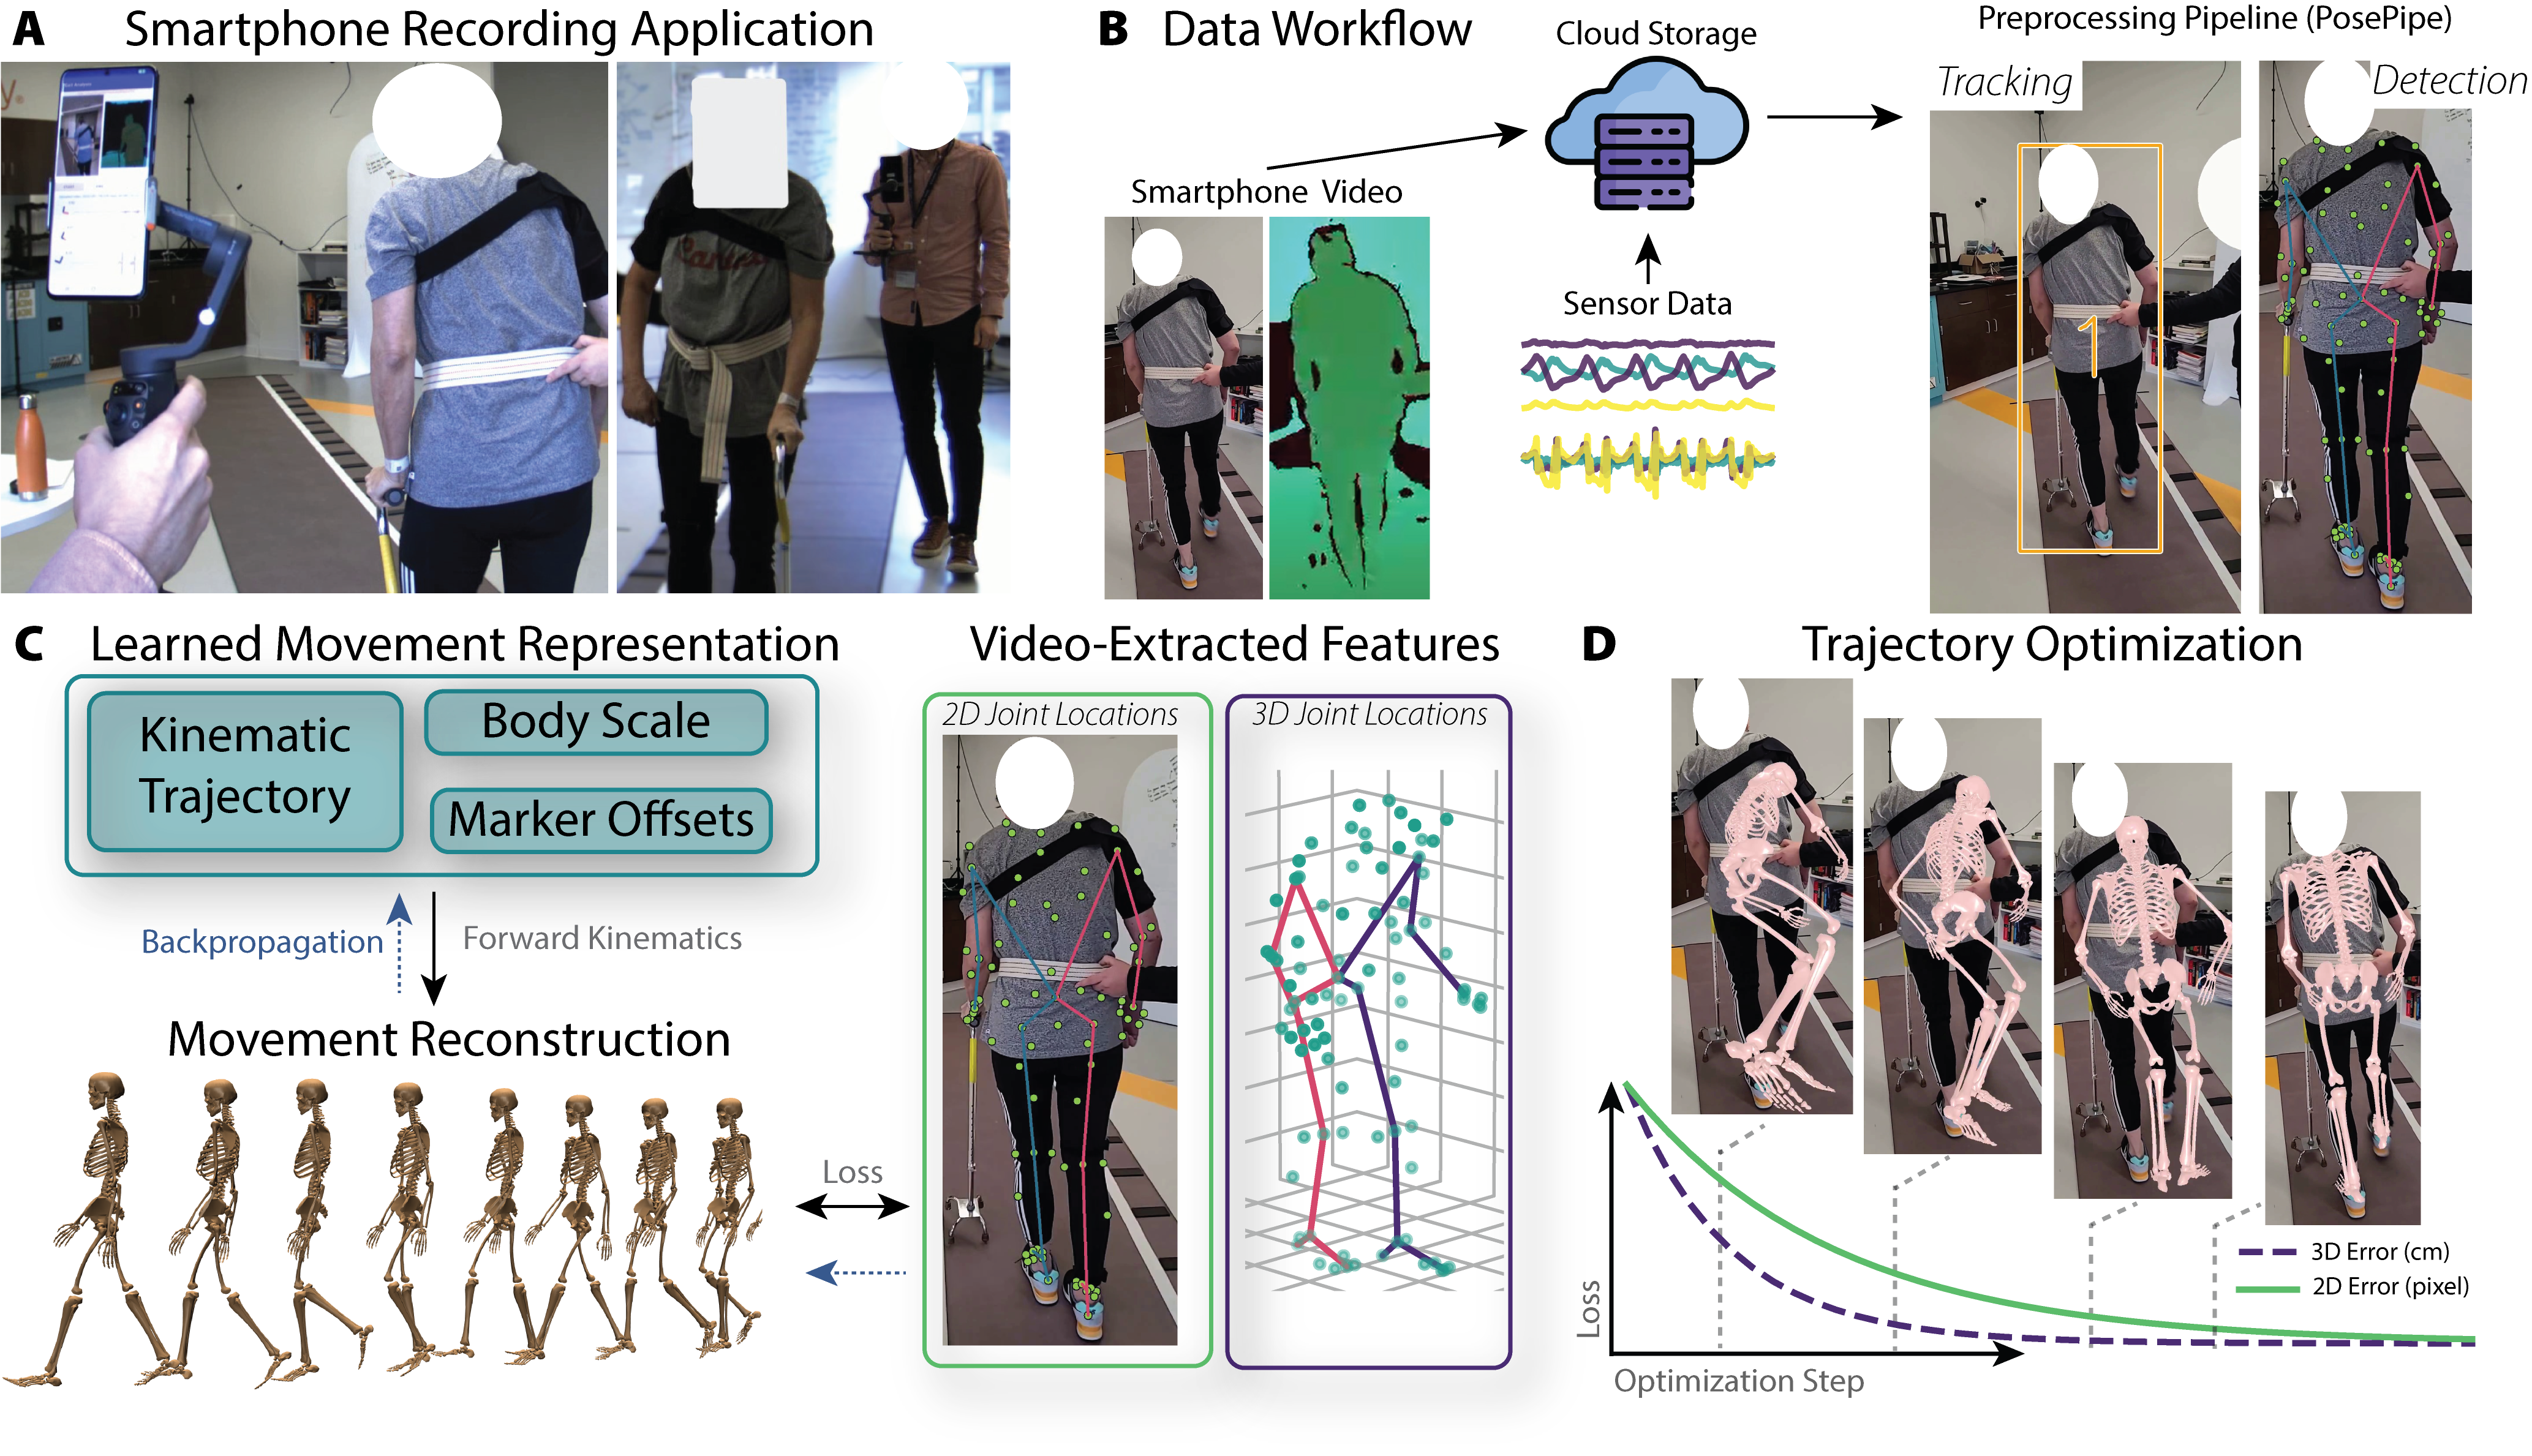

### Video processing code (takes several minutes)

Run these 5 cells (hidden) to process your video through the pipeline. Note this could take several minutes.

In [ ]:
# Note that we select the bml_movi_87 keypoints
# https://www.biomotionlab.ca/movi/

model = hub.load('https://bit.ly/metrabs_l')  # Takes about 3 minutes

# there are many skeleton formats support by this model. we are selecting one
# compatible with the gait transformer we will use below
skeleton = 'bml_movi_87'

# get the joint names and the edges between them for visualization below
joint_names = model.per_skeleton_joint_names[skeleton].numpy().astype(str)
joint_edges = model.per_skeleton_joint_edges[skeleton].numpy()

In [ ]:
from monocular_demos.utils import joint_names, video_reader
from tqdm import tqdm

vid, n_frames = video_reader(video_filepath)

print(f'About to processs {video_filepath} which has {n_frames} frames')
accumulated = None
for i, frame_batch in tqdm(enumerate(vid), total=n_frames//8):
    # use this for portrait videos on cell phone that are not detected
    if rotated:
        frame_batch = frame_batch.transpose(0, 2, 1, 3)

    pred = model.detect_poses_batched(frame_batch, skeleton=skeleton)

    if accumulated is None:
        accumulated = pred

    else:
        # concatenate the ragged tensor along the batch for each element in the dictionary
        for key in accumulated.keys():
            accumulated[key] = tf.concat([accumulated[key], pred[key]], axis=0)

    # if i > 10:
    #     break

In [ ]:
num_people = [p.shape[0] for p in accumulated['poses2d']]

if 0 in set(num_people):
    print('**WARNING** some frames with no people, make fail')

# assert this is 1 for all the frames
#assert len(set(num_people)) == 1

# then extract the information for that person
boxes = np.array([p[0] for p in accumulated['boxes'] if len(p) > 0])
pose3d = np.array([p[0] for p in accumulated['poses3d'] if len(p) > 0])
pose2d = np.array([p[0] for p in accumulated['poses2d'] if len(p) > 0])


In [ ]:
# For convenience, save the keypoints in case the notebook crashes or you have to restart

with open('keypoints3d.npz', 'wb') as f:
    np.savez(f, pose3d)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

frame_idx = 0

# Assuming pose3d and joint_names are already defined from your notebook

# Define the joint names you want to plot (those with capitalized letters)
capitalized_joint_names = [name for name in joint_names if any(c.isupper() for c in name)]

# Find the indices of the capitalized joint names in the original list
capitalized_joint_indices = [joint_names.index(name) for name in capitalized_joint_names]

# Extract the keypoints for the first time step, only for the capitalized joints
keypoints_t0_capitalized = pose3d[frame_idx, capitalized_joint_indices, :]

# Define the edges for the capitalized joints. You will need to manually define these
# based on the anatomical connections you want to visualize among the capitalized joints.
# This is a crucial step as the original joint_edges array might not directly
# map to the subset of capitalized joints.
# As an example, let's define some potential connections based on common human anatomy.
# You will need to adjust this based on the actual connections you want to show.
# The indices here refer to the indices *within* the `capitalized_joint_names` list.
capitalized_joint_edges = [
    (capitalized_joint_names.index('CHip'), capitalized_joint_names.index('LHip')),
    (capitalized_joint_names.index('CHip'), capitalized_joint_names.index('RHip')),
    (capitalized_joint_names.index('LHip'), capitalized_joint_names.index('LKnee')),
    (capitalized_joint_names.index('RHip'), capitalized_joint_names.index('RKnee')),
    (capitalized_joint_names.index('LKnee'), capitalized_joint_names.index('LAnkle')),
    (capitalized_joint_names.index('RKnee'), capitalized_joint_names.index('RAnkle')),
    (capitalized_joint_names.index('LAnkle'), capitalized_joint_names.index('LFoot')),
    (capitalized_joint_names.index('RAnkle'), capitalized_joint_names.index('RFoot')),
    (capitalized_joint_names.index('CHip'), capitalized_joint_names.index('Neck')),
    (capitalized_joint_names.index('Neck'), capitalized_joint_names.index('Head')),
    (capitalized_joint_names.index('Neck'), capitalized_joint_names.index('LShoulder')),
    (capitalized_joint_names.index('Neck'), capitalized_joint_names.index('RShoulder')),
    (capitalized_joint_names.index('LShoulder'), capitalized_joint_names.index('LElbow')),
    (capitalized_joint_names.index('RShoulder'), capitalized_joint_names.index('RElbow')),
    (capitalized_joint_names.index('LElbow'), capitalized_joint_names.index('LWrist')),
    (capitalized_joint_names.index('RElbow'), capitalized_joint_names.index('RWrist')),
    (capitalized_joint_names.index('LWrist'), capitalized_joint_names.index('LHand')),
    (capitalized_joint_names.index('RWrist'), capitalized_joint_names.index('RHand')),
]

### Visualize keypoints from a frame

Once the processing is complete, you can plot the 3D posistions of keypoints and verify they are what you would expect in your video.

In [ ]:


# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(121, projection='3d')

# Scatter plot of the capitalized keypoints
ax.scatter(keypoints_t0_capitalized[:, 0], keypoints_t0_capitalized[:, 2], keypoints_t0_capitalized[:, 1])

# Add labels for each capitalized joint
for i, (x, y, z) in enumerate(keypoints_t0_capitalized):
    ax.text(x, y, z, capitalized_joint_names[i], fontsize=9)

# Draw lines connecting the capitalized joints based on the defined edges
for i, j in capitalized_joint_edges:
    ax.plot(
        [keypoints_t0_capitalized[i, 0], keypoints_t0_capitalized[j, 0]],
        [keypoints_t0_capitalized[i, 2], keypoints_t0_capitalized[j, 2]],
        [keypoints_t0_capitalized[i, 1], keypoints_t0_capitalized[j, 1]],
        'k-',  # 'k-' means black solid line
        linewidth=1
    )


# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y (element 2)')
ax.set_zlabel('Z (element 1)')

# Set a title for the plot
ax.set_title('3D Scatter Plot and Skeleton')

# Set equal aspect ratio
max_range = np.array([keypoints_t0_capitalized[:,0].max() - keypoints_t0_capitalized[:,0].min(),
                      keypoints_t0_capitalized[:,2].max() - keypoints_t0_capitalized[:,2].min(),
                      keypoints_t0_capitalized[:,1].max() - keypoints_t0_capitalized[:,1].min()]).max()

mid_x = (keypoints_t0_capitalized[:,0].max() + keypoints_t0_capitalized[:,0].min()) * 0.5
mid_y = (keypoints_t0_capitalized[:,2].max() + keypoints_t0_capitalized[:,2].min()) * 0.5
mid_z = (keypoints_t0_capitalized[:,1].max() + keypoints_t0_capitalized[:,1].min()) * 0.5

ax.set_xlim(mid_x - max_range * 0.5, mid_x + max_range * 0.5)
ax.set_ylim(mid_y - max_range * 0.5, mid_y + max_range * 0.5)
ax.set_zlim(mid_z + max_range * 0.5, mid_z - max_range * 0.5)



ax = fig.add_subplot(122)

pose = pose3d[frame_idx]
# pose /= 1000.0
pose = pose - np.mean(pose, axis=0)

pose = pose[:, [0, 2, 1]]
pose[:, 2] *= -1

ax.plot(pose[:, 0], pose[:, 2], '.')
for e in joint_edges:
    ax.plot(pose[e, 0], pose[e, 2], 'k')
for i, p in enumerate(pose):
    ax.text(p[0]+0.05, p[2], f'{i}: {joint_names[i]}', fontsize=8)

ax.axis('equal')

# Show the plot
plt.show()

# Now compute kinematics end-to-end using a differentiable body model

This uses an implicit representation $f_\theta: t \rightarrow \theta \in \mathbb R^{40}$, which is then passed through the forward kinematic model to get the predicted 3D keypoints: $\mathcal M_\beta: \theta \rightarrow \mathbf y \in \mathbb R^{87 \times 3}$.

We optimize the difference between the predicted 3D keypoints and the detected 3D keypoints.

In [ ]:
with open('keypoints3d.npz', 'rb') as f:
    pose3d = np.load(f, allow_pickle=True)['arr_0']

# exclude any frames where people were missed to make the code work reliably
pose3d = np.array([p[0] for p in accumulated['poses3d']])

In [ ]:
# build a dataset that includes the timestamps and 3D pose estimates

from jax import numpy as jnp

# convert pose to m
pose = pose3d
pose = pose[:, :, [0, 2, 1]]
pose[:, :, 2] *= -1
pose /= 1000.0

pose = pose - np.min(pose, axis=1, keepdims=True)

timestamps = jnp.arange(len(pose)) / 30.0

dataset = (timestamps, pose)

## This is a minimal example of differentiable biomechanics

It will take a minute to start fitting as the jax just-in-time compilation occurs

In [ ]:
from jaxtyping import Integer, Float, Array, PRNGKeyArray
from typing import Tuple, Dict
from tqdm import trange
import equinox as eqx
import optax

from monocular_demos.biomechanics_mjx.monocular_trajectory import KineticsWrapper, get_default_wrapper

# construct a loss function between the forward pass through the forward kinematic
# implicit representation and the resulting keypoint and the detected keypoitns

def loss(
    model: KineticsWrapper,
    x: Float[Array, "times"],
    y: Float[Array, "times keypoints 3"],
    site_offset_regularization = 1e-1
) -> Tuple[Float, Dict]:

    timestamps = x
    keypoints3d = y
    metrics = {}

    # NOTE: steps is an make sure this retraces for different dimensions
    (state, constraints, next_states), (ang, vel, action), _ = model(
        timestamps,
        skip_vel=True,
        skip_action=True,
    )

    pred_kp3d = state.site_xpos

    l = jnp.mean((pred_kp3d - keypoints3d) ** 2) * 100 # so in cm
    metrics["kp_err"] = l

    # regularize marker offset
    l_site_offset = jnp.sum(jnp.square(model.site_offsets))
    l += l_site_offset * site_offset_regularization

    # make loss the first key in the dictionary by popping and building a new dictionary with the rest
    metrics = {"loss": l, **metrics}

    return l, metrics


@eqx.filter_jit
def step(model, opt_state, data, loss_grad, optimizer, **kwargs):
    x, targets = data

    (val, metrics), grads = loss_grad(model, x=x, y=targets, **kwargs)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return val, model, opt_state, metrics


def fit_model(
    model: KineticsWrapper,
    dataset: Tuple,
    lr_end_value: float = 1e-8,
    lr_init_value: float = 1e-4,
    max_iters: int = 5000,
    clip_by_global_norm: float = 0.1,
):

    # work out the transition steps to make the desired schedule
    transition_steps = 10
    lr_decay_rate = (lr_end_value / lr_init_value) ** (1.0 / (max_iters // transition_steps))
    learning_rate = optax.warmup_exponential_decay_schedule(
        init_value=0,
        warmup_steps=0,
        peak_value=lr_init_value,
        end_value=lr_end_value,
        decay_rate=lr_decay_rate,
        transition_steps=transition_steps,
    )

    optimizer = optax.chain(
        optax.adamw(learning_rate=learning_rate, b1=0.8, weight_decay=1e-5), optax.zero_nans(), optax.clip_by_global_norm(clip_by_global_norm)
    )
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    loss_grad = eqx.filter_value_and_grad(loss, has_aux=True)

    counter = trange(max_iters)
    for i in counter:

        val, model, opt_state, metrics = step(model, opt_state, dataset, loss_grad, optimizer)

        if i > 0 and i % int(max_iters // 10) == 0:
            print(f"\niter: {i} loss: {val}.")  # metrics: {metrics}")

        if i % 50 == 0:
            metrics = {k: v.item() for k,v in metrics.items()}
            counter.set_postfix(metrics)

    return model, metrics


fkw = get_default_wrapper()
updated_model, metrics = fit_model(fkw, dataset)

# Now explore the results


In [ ]:
# pass the timestamps through the fitted model to get the kinematics
(state, constraints, next_states), (ang, vel, action), _ = updated_model(dataset[0], skip_vel=True, skip_action=True)

knee_idx = jnp.array([fk.joint_names.index(n) for n in ['knee_angle_r', 'knee_angle_l']])
# plot the knees
plt.figure()
plt.plot(dataset[0], -np.degrees(ang[:, knee_idx]))
plt.xlabel('Time (s)')
plt.ylabel('Knee angle (deg)');

In [ ]:
# And create a MuJoCo visualization

from monocular_demos.biomechanics_mjx.visualize import render_trajectory, jupyter_embed_video

fn = 'reconstruction.mp4'
render_trajectory(ang, fn, xml_path=None)
HTML = jupyter_embed_video(fn)
HTML

# Gait Transformer

We will use the gait transformer to convert 3D keypoints into interpretable gait cycles. Training this algorithm is described here: https://arxiv.org/abs/2203.09371 and a validation of it in clinical practice is here: https://pubmed.ncbi.nlm.nih.gov/38360820/.


The code we will be using can be found at https://github.com/peabody124/GaitTransformer

The original code used [PosePipe](https://github.com/peabody124/PosePipeline/) to handle the different steps of the processing algorithm (shown below). These included:
- using DeepSort for tracking
- using mmpose to compute the 2D keypoitns
- using GastNet to lift from 2D to 3D keypoints, which was trained to output the MPI-INF 17 keypoints


Here we are going to use [MeTRAbs-ACAE](https://istvansarandi.com/dozens/), which performs all of these steps together and takes in images and directly produces high quality 3D keypoints in a variety of formats.

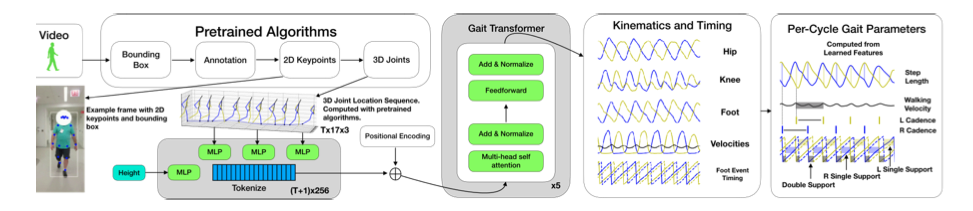

Next, we reprocess keypoints with a different skeleton format that makes the gait transformer easy to overlay.

In [ ]:
from monocular_demos.utils import joint_names, video_reader
from tqdm import tqdm

# there are many skeleton formats support by this model. we are selecting one
# compatible with the gait transformer we will use below
skeleton = 'mpi_inf_3dhp_17'

# get the joint names and the edges between them for visualization below
joint_names = model.per_skeleton_joint_names[skeleton].numpy().astype(str)
joint_edges = model.per_skeleton_joint_edges[skeleton].numpy()


vid, n_frames = video_reader(video_filepath)

print(f'About to processs {video_filepath} which has {n_frames} frames')
accumulated = None
for i, frame_batch in tqdm(enumerate(vid), total=n_frames//8):
    # use this for portrait videos on cell phone that are not detected
    if rotated:
        frame_batch = frame_batch.transpose(0, 2, 1, 3)

    pred = model.detect_poses_batched(frame_batch, skeleton=skeleton)

    if accumulated is None:
        accumulated = pred

    else:
        # concatenate the ragged tensor along the batch for each element in the dictionary
        for key in accumulated.keys():
            accumulated[key] = tf.concat([accumulated[key], pred[key]], axis=0)


Then, we ensure there is at least 1 person in each frame. If this fails, it means there are some frames where there are no people.

In [ ]:
num_people = [p.shape[0] for p in accumulated['poses2d']]

if 0 in set(num_people):
    print('**WARNING** some frames with no people, make fail')

# assert this is 1 for all the frames
#assert len(set(num_people)) == 1

# then extract the information for that person
boxes = np.array([p[0] for p in accumulated['boxes'] if len(p) > 0])
pose3d = np.array([p[0] for p in accumulated['poses3d'] if len(p) > 0])
pose2d = np.array([p[0] for p in accumulated['poses2d'] if len(p) > 0])

In [ ]:
# this is the order of joints from the Gast-NET algorithm that the gait transformer was originally trained on
expected_order = ['pelv', 'rhip', 'rkne', 'rank', 'lhip', 'lkne', 'lank', 'spin', 'neck', 'head', 'htop', 'lsho', 'lelb', 'lwri', 'rsho', 'relb', 'rwri']
expected_order_idx = np.array([joint_names.tolist().index(j) for j in expected_order])

# GastNet also produces centered data
#keypoints = pose3d - np.mean(pose3d, axis=1, keepdims=True)
keypoints = pose3d - pose3d[:, joint_names.tolist().index('pelv'), None]

# we should also convert the mm output from MeTRAbs to the expected meters
keypoints = keypoints / 1000.0      # convert mm to m

# finally convert the axis order and signs to be compatible
keypoints = keypoints[:, :, [0, 2, 1]]
keypoints = keypoints[:, expected_order_idx]
keypoints[:, :, 2] *= -1


In [ ]:
from gait_transformer.gait_phase_transformer import load_default_model, gait_phase_stride_inference

transformer_model = load_default_model()

Here you will want to set your participant's hieght (in mm) and set the window length. This needs to be increased for people with very slow cadences.

In [ ]:
# include the height of the participant
# nominally this should be correct but won't affect timing

height_mm = 1778

# set the window length the transformer processes. this should be enough
# to get at least a gait cycle or two
L = 90

phase, stride = gait_phase_stride_inference(keypoints, height_mm, transformer_model, L)

1it [00:01,  1.00s/it]


In [ ]:
fig, ax = plt.subplots(1,1,sharex=True)
ax.plot(timestamps, phase[:, :4]); # plot the four cos compents of the gait events

You can now visualize the gait events during the video. The circles will turn red when the foot is in contact with the ground (stance phase) and green while off the ground (swing phase)

In [ ]:
from gait_transformer.visualization import make_overlay, jupyter_embed_video

phase_ordered = np.take(phase, [0, 4, 1, 5, 2, 6, 3, 7], axis=-1)

output_video = make_overlay(video_filepath, phase_ordered, stride, pose2d, "result.mp4")
jupyter_embed_video(output_video, height=640)

# Now apply the kalman filter and extract gait events

The KF expect a periodic underlying structure from the phases of the gait transformer with a fixed offset between the gait events from the overall gait phase ($\phi_i$).


In [ ]:
from gait_transformer.gait_phase_kalman import gait_kalman_smoother, compute_phases, get_event_times

# kalman filter expects cos, sin alternating instead of the output from the gait transformer
# which is the four cos and then the four sin

phase_ordered = np.take(phase, [0, 4, 1, 5, 2, 6, 3, 7], axis=-1)
state, predictions, errors = gait_kalman_smoother(phase_ordered)

plt.figure()
plt.plot(timestamps, errors)
plt.title('Error between KF reconstruction, high when tracking poorly')
plt.xlabel('Time (s)')

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(timestamps, state[:, 0])
ax[0].set_ylabel('Cycles (rad)')

ax[1].plot(timestamps, state[:, 1], label='Cadence (rad/s)')
ax[1].plot(timestamps, state[:, 2], label='$\phi_0 (rad)')
ax[1].plot(timestamps, state[:, 3], label='$\phi_1 (rad)')
ax[1].plot(timestamps, state[:, 4], label='$\phi_2 (rad)')
ax[1].set_ylabel('Phase')
ax[1].set_xlabel('Time (s)')
plt.legend();

Finally, you can extract the timestamps for all gait events. Down is initial contact, and up is toe-off.

In [ ]:
# Get the timestamps for gait events

timestamps = np.arange(state.shape[0]) / 30.0
get_event_times(state, timestamps)

In [ ]:
def calculate_all_gait_parameters(pose3d, gait_events, fps=30):
    """Calculate all gait parameters"""

    # Joint indices
    left_ankle_idx = 13
    right_ankle_idx = 10
    right_wrist_idx = 4
    left_wrist_idx = 7

    # Extract positions
    left_ankle_pos = pose3d[:, left_ankle_idx, :]
    right_ankle_pos = pose3d[:, right_ankle_idx, :]

    # Convert times to frames
    left_down = np.array(gait_events['left_down'])
    right_down = np.array(gait_events['right_down'])

    left_down_frames = (left_down * fps).astype(int)
    right_down_frames = (right_down * fps).astype(int)

    # CADENCE
    total_steps = len(left_down) + len(right_down)
    start_time = min(left_down[0], right_down[0])
    end_time = max(left_down[-1], right_down[-1])
    duration_min = (end_time - start_time) / 60
    cadence = total_steps / duration_min

    # STEP TIMES
    all_heel_strikes = []
    for t in left_down:
        all_heel_strikes.append((t, 'L'))
    for t in right_down:
        all_heel_strikes.append((t, 'R'))
    all_heel_strikes.sort(key=lambda x: x[0])

    step_times = []
    left_step_times = []
    right_step_times = []

    for i in range(len(all_heel_strikes) - 1):
        step_time = all_heel_strikes[i+1][0] - all_heel_strikes[i][0]
        step_times.append(step_time)
        if all_heel_strikes[i][1] == 'L':
            left_step_times.append(step_time)
        else:
            right_step_times.append(step_time)

    step_times = np.array(step_times)
    step_time_variability = np.std(step_times)
    step_time_asymmetry = abs(np.mean(left_step_times) - np.mean(right_step_times))

    # STEP LENGTH & WIDTH
    all_hs_spatial = []
    for frame in left_down_frames:
        if frame < len(pose3d):
            all_hs_spatial.append(('L', frame, left_ankle_pos[frame]))
    for frame in right_down_frames:
        if frame < len(pose3d):
            all_hs_spatial.append(('R', frame, right_ankle_pos[frame]))

    all_hs_spatial.sort(key=lambda x: x[1])

    step_lengths = []
    step_widths = []

    for i in range(len(all_hs_spatial) - 1):
        foot1, _, pos1 = all_hs_spatial[i]
        foot2, _, pos2 = all_hs_spatial[i+1]

        step_lengths.append(np.linalg.norm(pos2 - pos1))
        if foot1 != foot2:
            step_widths.append(abs(pos2[2] - pos1[2]))

    step_lengths = np.array(step_lengths)
    step_widths = np.array(step_widths)

    gait_speed = (np.sum(step_lengths) / 1000) / (end_time - start_time)

    # ARM SWING
    right_wrist = pose3d[:, right_wrist_idx, :]
    left_wrist = pose3d[:, left_wrist_idx, :]
    right_arm_swing = np.max(right_wrist[:, 0]) - np.min(right_wrist[:, 0])
    left_arm_swing = np.max(left_wrist[:, 0]) - np.min(left_wrist[:, 0])
    arm_swing = (right_arm_swing + left_arm_swing) / 2

    return {
        'cadence': cadence,
        'gait_speed': gait_speed,
        'step_length_mean': np.mean(step_lengths),
        'step_length_sd': np.std(step_lengths),
        'step_width_mean': np.mean(step_widths),
        'step_width_sd': np.std(step_widths),
        'arm_swing': arm_swing,
        'step_time_asymmetry': step_time_asymmetry,
        'step_time_variability': step_time_variability
    }


In [ ]:
# Calculate all parameters
params = calculate_all_gait_parameters(pose3d, gait_events)

# Display results
print("=" * 50)
print("GAIT ANALYSIS RESULTS")
print("=" * 50)
print(f"\nCadence: {params['cadence']:.1f} steps/min")
print(f"Gait Speed: {params['gait_speed']:.2f} m/s")
print(f"Step Length: {params['step_length_mean']:.1f} ± {params['step_length_sd']:.1f} mm")
print(f"Step Width: {params['step_width_mean']:.1f} ± {params['step_width_sd']:.1f} mm")
print(f"Arm Swing: {params['arm_swing']:.1f} mm")
print(f"Step Time Variability: {params['step_time_variability']:.3f} sec")
print(f"Step Time Asymmetry: {params['step_time_asymmetry']:.3f} sec")
print("=" * 50)
